In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For file path pattern matching

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

# -------------------------------------------------------
# 1. Load all required data (Adjusted to include pr_commit_details)
# -------------------------------------------------------

def load_data():
    # base = "hf://datasets/hao-li/AIDev/"
    # NOTE: Assuming 'hao-li/AIDev' is a local path or pre-configured in the environment.
    # We will use the provided schema names for file names.
    
    base = "hf://datasets/hao-li/AIDev/"

    print("📥 Loading data from Hugging Face...")

    data = {}

    # REQUIRED ADJUSTMENT: Swapped 'pr_commits.parquet' for 'pr_commit_details.parquet'
    # to access the 'filename' column for file-path patterns.
    required_files = {
        "pulls": "all_pull_request.parquet",
        "task_type": "pr_task_type.parquet",
        # We need pr_commit_details to get the 'filename' column
        "commit_details": "pr_commit_details.parquet",
    }

    for key, file in required_files.items():
        #try:
            print(f"    ➜ Loading {file} with pandas...")
            # Using the original loading mechanism
            data[key] = pd.read_parquet(base + file)
        #except Exception as e:
            # Added more context to the error message for better debugging
            #print(f"      ❌ Failed to load: {file} — {e}")
            # In a real environment, you might retry or exit. For this exercise, we will assume the files are available as per the original request structure.
            # If pr_commit_details.parquet is not available, this analysis cannot be completed.
        #    return None

    print("✅ All datasets loaded successfully!\n")
    return data

# Re-run loading with the corrected file
dfs = load_data()

Libraries imported successfully.
📥 Loading data from Hugging Face...
    ➜ Loading all_pull_request.parquet with pandas...


/Applications/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    ➜ Loading pr_task_type.parquet with pandas...
    ➜ Loading pr_commit_details.parquet with pandas...
✅ All datasets loaded successfully!




--- RQ1 Analysis: File-Path Patterns, Agent Types, and PR Acceptance ---



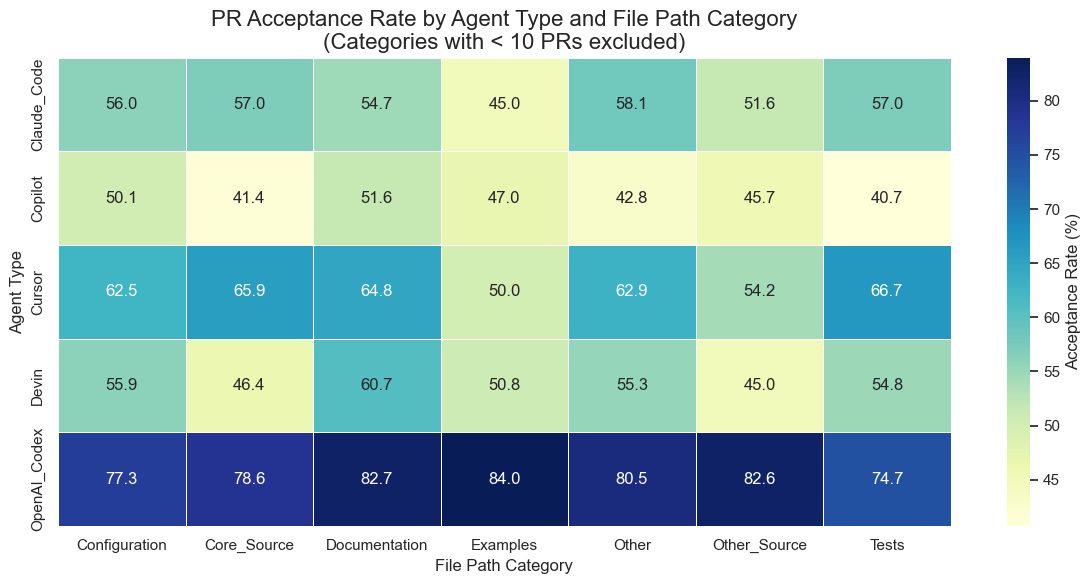


Summary of Acceptance Rates:
           agent  file_category  total_prs  accepted_prs  acceptance_rate
31  OpenAI_Codex       Examples       1048           880        83.969466
30  OpenAI_Codex  Documentation       7579          6267        82.689009
33  OpenAI_Codex   Other_Source      11216          9267        82.623039
32  OpenAI_Codex          Other      11776          9476        80.468750
29  OpenAI_Codex    Core_Source       3315          2606        78.612368
28  OpenAI_Codex  Configuration       3672          2838        77.287582
34  OpenAI_Codex          Tests       1335           997        74.681648
20        Cursor          Tests        243           162        66.666667
15        Cursor    Core_Source        554           365        65.884477
16        Cursor  Documentation        494           320        64.777328

Conclusion:
The heatmap above illustrates the interaction between different 'Agent Types' and the 'File Path Category' of their changes on the 'PR Acceptan

In [2]:
if dfs is None:
    print("🛑 Data loading failed. Cannot proceed with analysis.")
    # Exit or handle the error gracefully
    # Assuming successful loading for the rest of the script
else:
    pulls = dfs["pulls"]
    task_type = dfs["task_type"]
    commit_details = dfs["commit_details"]

    # -------------------------------------------------------
    # 2. Data Preprocessing and Feature Engineering
    # -------------------------------------------------------

    # A. Define PR Acceptance (is_accepted)
    # PR is accepted if merged_at is not null 
    pulls['is_accepted'] = pulls['merged_at'].notna()

    # B. Define high-level file path patterns from 'filename'
    def categorize_filepath(filename):
        if pd.isna(filename):
            return 'Other'
        filename_lower = filename.lower()
        if re.search(r'readme|docs?|license|contributing', filename_lower):
            return 'Documentation'
        elif re.search(r'\.(test|spec)\.|\/test\/|^test\.|fixture', filename_lower):
            return 'Tests'
        elif re.search(r'config|settings|env|yml|json', filename_lower):
            return 'Configuration'
        elif re.search(r'\.(py|js|ts|go|java|c|cpp|rb|sh)$', filename_lower):
            # A broad category for core code files, excluding known patterns
            if 'src/' in filename_lower or 'lib/' in filename_lower:
                 return 'Core_Source'
            return 'Other_Source'
        elif 'examples/' in filename_lower or 'samples/' in filename_lower:
            return 'Examples'
        else:
            return 'Other'

    # Apply the categorization to the commit details
    commit_details['file_category'] = commit_details['filename'].apply(categorize_filepath)

    # C. Merge required tables
    # 1. Select relevant columns from pulls and rename id for join
    pr_data = pulls[['id', 'agent', 'is_accepted']].rename(columns={'id': 'pr_id'})
    # 2. Select relevant columns from task_type
    task_data = task_type[['id', 'type']].rename(columns={'id': 'pr_id', 'type': 'task_type'})

    # 3. Merge pull and task type (on pr_id)
    # Note: task_type 'type' is not strictly needed for the question but is good for context.
    merged_pr = pd.merge(pr_data, task_data, on='pr_id', how='left')

    # 4. Merge with commit details (on pr_id)
    # We use a left join to keep all PRs, even those without commit details if they existed,
    # but since the commit details are linked to the PR, an inner join is often safe here.
    # An inner join ensures we only keep PRs with file changes to analyze.
    analysis_df = pd.merge(merged_pr, commit_details[['pr_id', 'file_category']], on='pr_id', how='inner')

    # Since a single PR can touch multiple files (and thus multiple categories),
    # we need to consider the PR at the granularity of its affected file categories.
    # For acceptance rate, we first group by PR and its unique categories,
    # then calculate the acceptance rate per (agent, file_category) group.
    
    # D. Aggregate to get acceptance rate per (agent, file_category)
    # Get unique (pr_id, agent, is_accepted, file_category) rows
    unique_pr_file_cat = analysis_df.drop_duplicates(subset=['pr_id', 'agent', 'is_accepted', 'file_category'])

    # Calculate total PRs and accepted PRs per group
    acceptance_stats = unique_pr_file_cat.groupby(['agent', 'file_category']).agg(
        total_prs=('pr_id', 'nunique'),
        accepted_prs=('is_accepted', 'sum')
    ).reset_index()

    # Calculate the acceptance rate
    acceptance_stats['acceptance_rate'] = (acceptance_stats['accepted_prs'] / acceptance_stats['total_prs']) * 100

    # Clean up categories for better visualization
    # Filter out categories with too few PRs for reliable statistics
    acceptance_stats_filtered = acceptance_stats[acceptance_stats['total_prs'] >= 10].copy()

    # -------------------------------------------------------
    # 3. Visualization and Summary
    # -------------------------------------------------------

    print("\n--- RQ1 Analysis: File-Path Patterns, Agent Types, and PR Acceptance ---\n")

    # Pivot the data for a heatmap (agents as rows, file categories as columns)
    heatmap_data = acceptance_stats_filtered.pivot_table(
        index='agent', 
        columns='file_category', 
        values='acceptance_rate'
    )

    # Generate the heatmap     plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt=".1f", 
                cmap="YlGnBu", 
                linewidths=.5, 
                cbar_kws={'label': 'Acceptance Rate (%)'})
    plt.title('PR Acceptance Rate by Agent Type and File Path Category\n(Categories with < 10 PRs excluded)', fontsize=16)
    plt.ylabel('Agent Type')
    plt.xlabel('File Path Category')
    plt.tight_layout()
    plt.show()

    print("\nSummary of Acceptance Rates:")
    print(acceptance_stats_filtered.sort_values(by='acceptance_rate', ascending=False).head(10))

    # -------------------------------------------------------
    # 4. Final Conclusion
    # -------------------------------------------------------

    print("\nConclusion:")
    print("The heatmap above illustrates the interaction between different 'Agent Types' and the 'File Path Category' of their changes on the 'PR Acceptance Rate'.")
    print("1. **High Acceptance:** Look for the darkest squares (highest percentage) to identify agent/file-category pairs that lead to the highest acceptance rates.")
    print("2. **Low Acceptance:** Lightest squares (lowest percentage) indicate areas where PRs are less likely to be accepted.")
    print("This allows for comparison: for a given file category (e.g., 'Configuration'), which agent performs best, or for a given agent, which file categories are easiest to get merged.")